# nCoV-2019

Data Source: 
    https://en.m.wikipedia.org/wiki/Timeline_of_the_2019–20_Wuhan_coronavirus_outbreak

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 28 08:19:13 2020

"""

import datetime as dt

import warnings
warnings.filterwarnings("ignore")
#import time

#import packages
import pandas as pd
import numpy as np
import xlrd
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import pandas_datareader as pdr
from tabulate import tabulate
from matplotlib import style
from matplotlib.pylab import rcParams
style.use('fivethirtyeight')
#style.use('ggplot')


In [2]:
df_xls=pd.read_excel(r'Corona.xlsx')

#Eliminating sparse data
df=df_xls[7:]

In [3]:
df=df.reset_index(drop=True)

In [4]:
df

,Date,Cases Suspected,Cases Confirmed,Deaths,Recovered,Quarantined,Quarantined & Released,Total,Source,Cases Confirm Outside China
0,2020.01.15,NaN,41.0,2.0,7.0,119.0,644.0,763.0,[10],NaN
1,2020.01.16,NaN,45.0,2.0,12.0,98.0,665.0,763.0,[11],NaN
2,2020.01.17,NaN,62.0,2.0,15.0,82.0,681.0,763.0,[12],NaN
3,2020.01.18,NaN,121.0,2.0,19.0,NaN,NaN,NaN,NaN,NaN
4,2020.01.19,NaN,198.0,3.0,25.0,90.0,727.0,817.0,[13],4.0
5,2020.01.20,54.0,291.0,6.0,25.0,922.0,817.0,1739.0,[14][15],6.0
6,2020.01.21,37.0,440.0,9.0,25.0,1394.0,765.0,2159.0,[16],8.0
7,2020.01.22,257.0,571.0,17.0,25.0,4928.0,969.0,5897.0,[17],14.0
8,2020.01.23,1072.0,830.0,25.0,34.0,8420.0,1087.0,9507.0,[18],25.0
9,2020.01.24,1965.0,1287.0,41.0,38.0,13967.0,1230.0,15197.0,[19],40.0


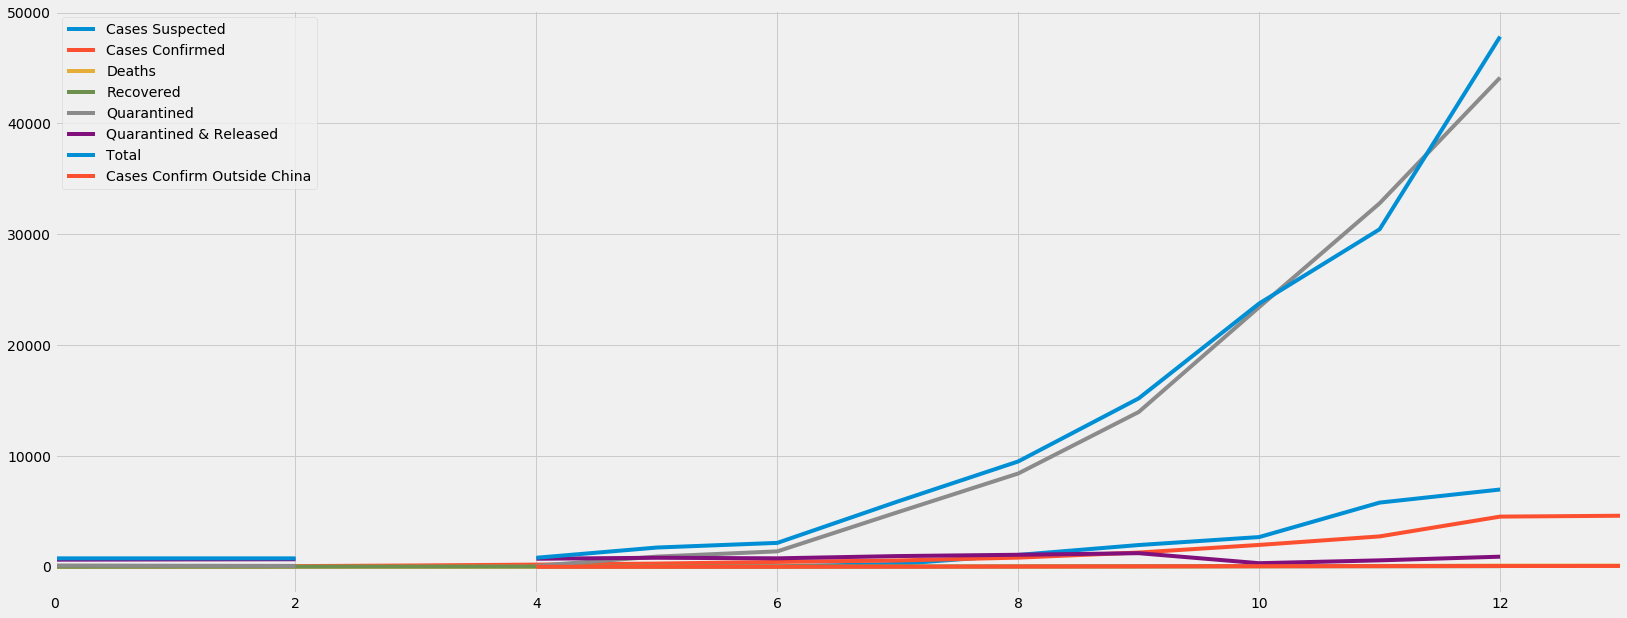

In [5]:
rcParams['figure.figsize'] = 25,10
df.plot()

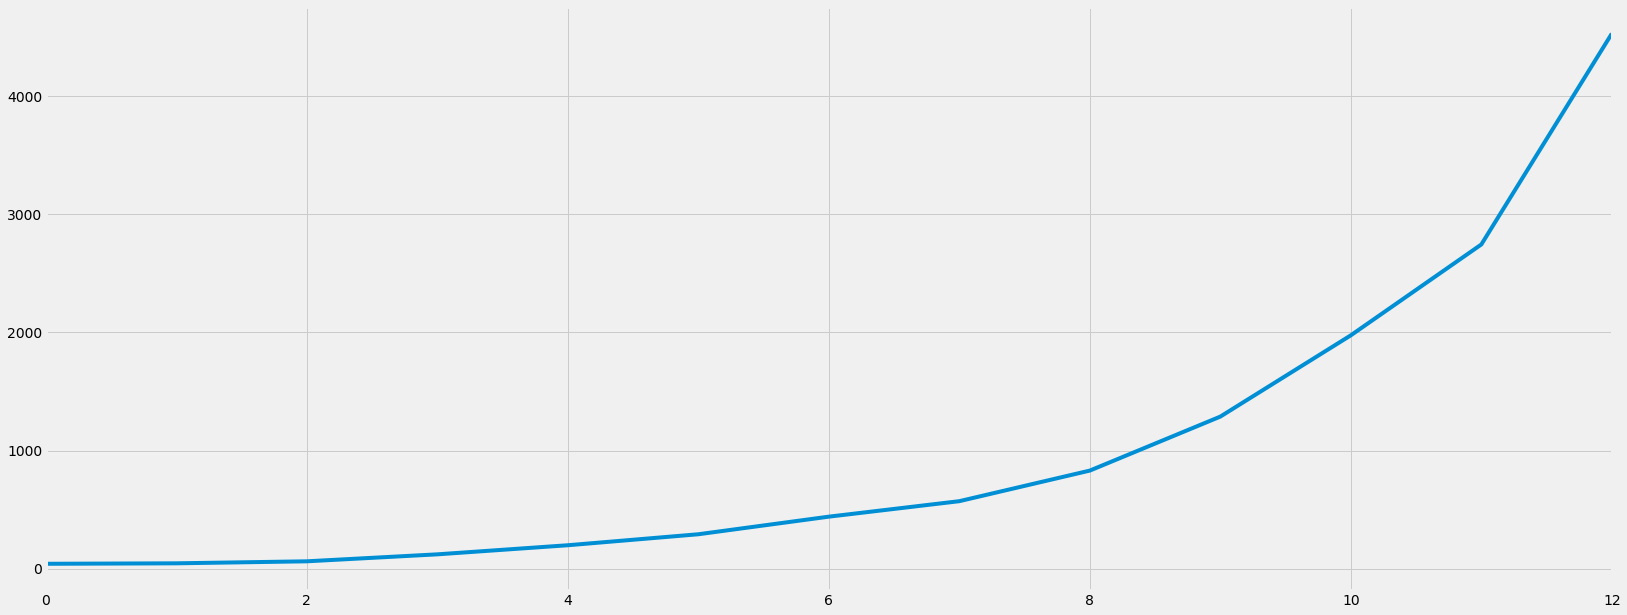

In [6]:
df_cc = df[:13]['Cases Confirmed']
df_cc.plot()

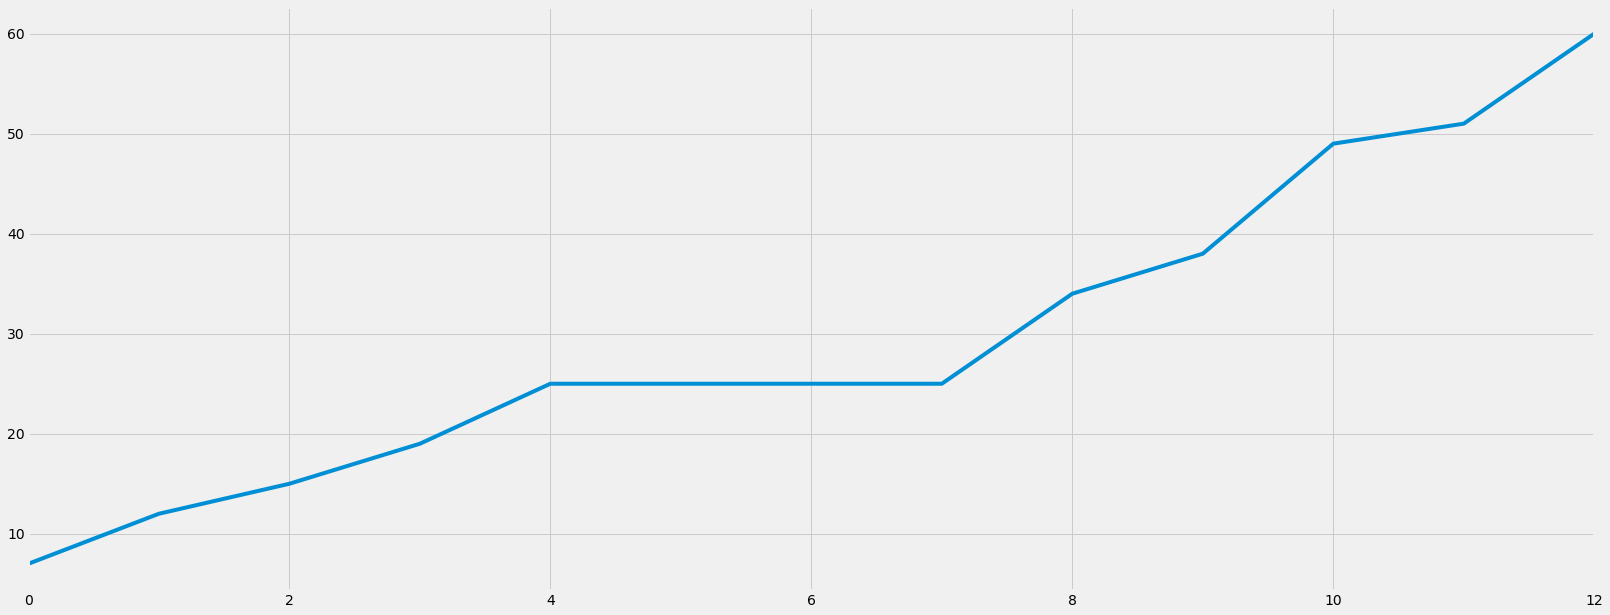

In [7]:
df_r = df[:13]['Recovered']
df_r.plot()

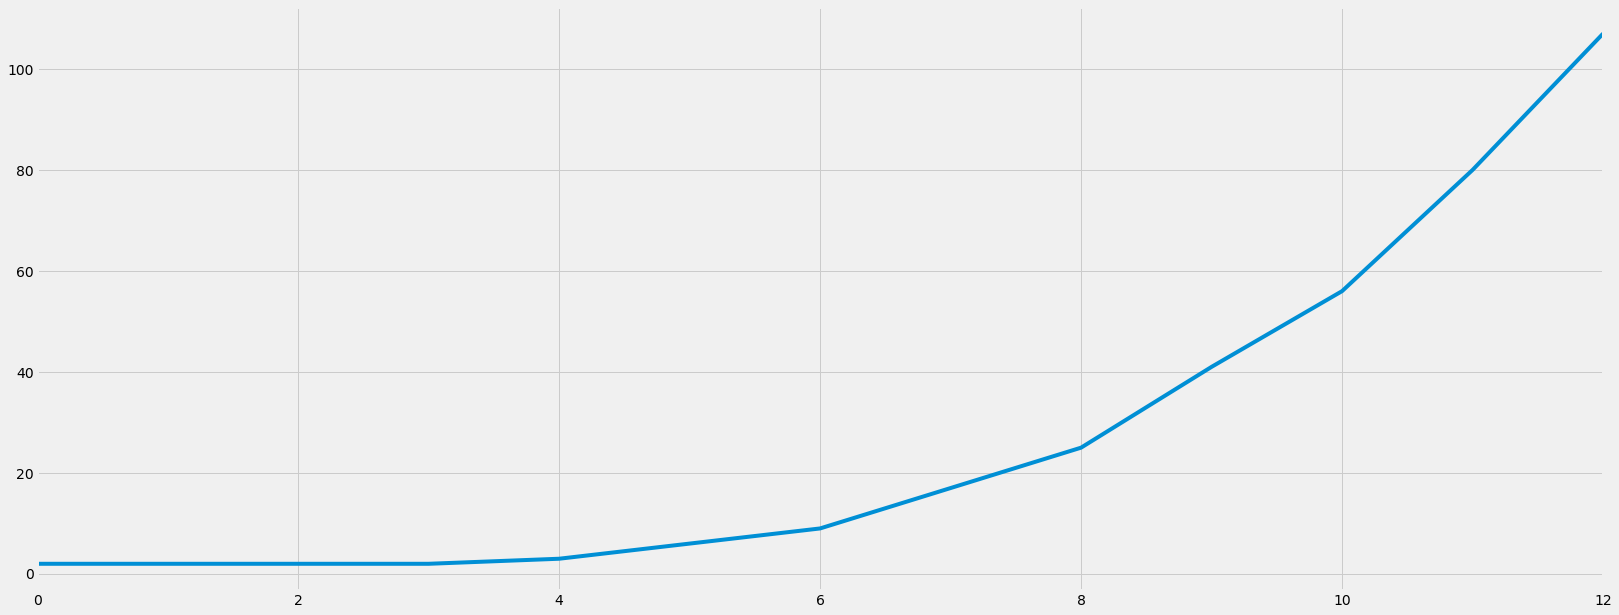

In [8]:
df_d = df[:13]['Deaths']
df_d.plot()

In [9]:
def exponential_fit(x, a, b, c):
    return a*np.exp(b*x) + c

In [10]:
df_cc

0       41.0
1       45.0
2       62.0
3      121.0
4      198.0
5      291.0
6      440.0
7      571.0
8      830.0
9     1287.0
10    1975.0
11    2744.0
12    4529.0
Name: Cases Confirmed, dtype: float64

In [11]:
type(df_cc)

pandas.core.series.Series

In [12]:
y=np.array(df_cc)
x=np.array(df_cc.index)

In [13]:
type(y)

numpy.ndarray

In [14]:
y[:12]

array([  41.,   45.,   62.,  121.,  198.,  291.,  440.,  571.,  830.,
       1287., 1975., 2744.])

In [15]:
x[:12]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

In [16]:
#Fit Data
#Dropped the last data point in the fit, and used it as a test for the fit
fitting_parameters, covariance = curve_fit(exponential_fit, x[:12], y[:12])
a, b, c = fitting_parameters

In [17]:
fitting_parameters

array([ 43.74881467,   0.37771771, -13.73969404])

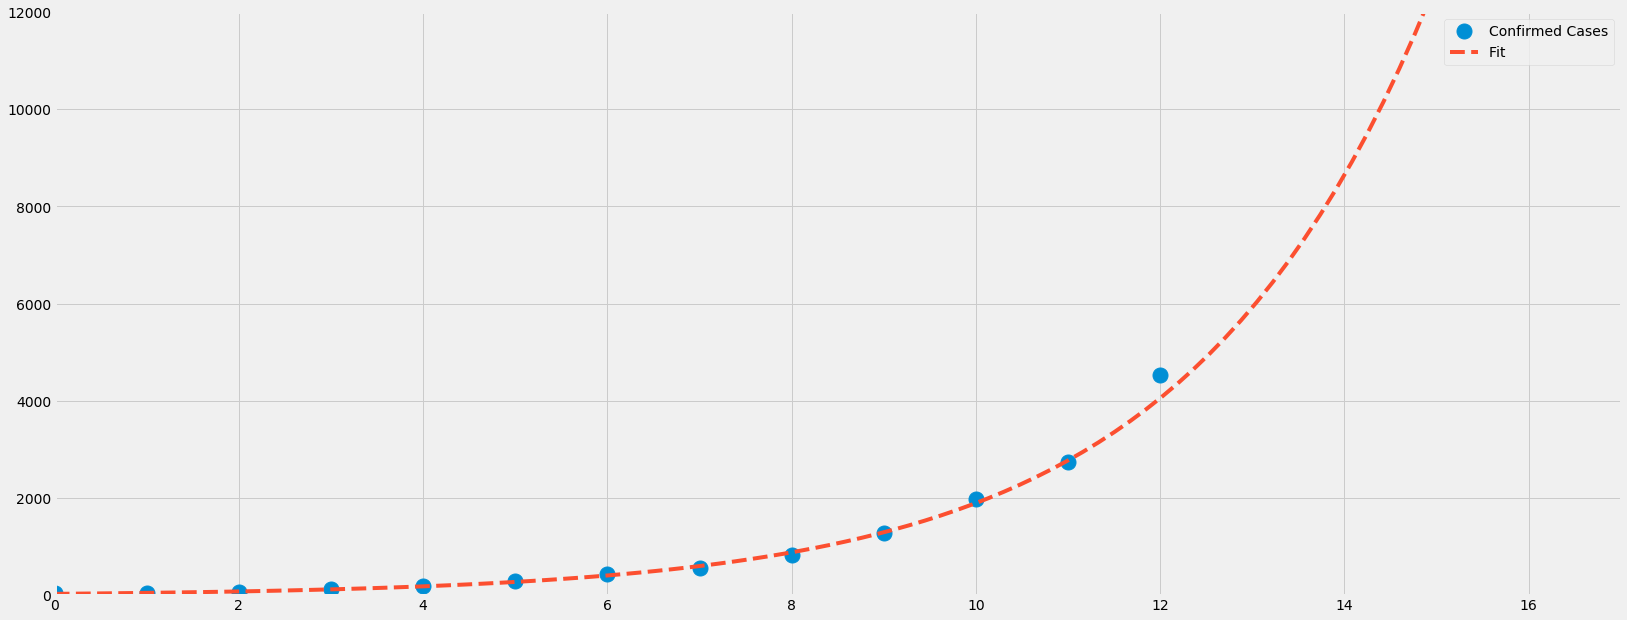

In [18]:
#Plot Curve Fit with Data 
x_min = 0  
x_max = 17
y_min = 0
y_max = 12000
x_fit = np.linspace(x_min, x_max, 100)   
plt.plot(x, y, 'o', markersize=15, label='Confirmed Cases')
plt.plot(x_fit, exponential_fit(x_fit, *fitting_parameters), '--', label='Fit')

plt.axis([x_min, x_max, y_min, y_max])
plt.legend()
plt.show()